<a href="https://colab.research.google.com/github/AnastasiiaVladimirovna/transcriptomics_homeworks/blob/main/hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install scanpy[leiden] anndata2ri scikit-misc scvi-tools scvelo
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown "1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck&confirm=t"
!tar xf library.tar.gz

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

In [ ]:
import anndata2ri
anndata2ri.activate()

!pip install rpy2==3.5.1
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

In [ ]:

# Установка пакета glmGamPoi, необходимого для SCTransform
import rpy2.robjects as ro
ro.r('BiocManager::install("glmGamPoi")')

In [ ]:

import scanpy as sc
import seaborn as sns
import scvelo as scv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("ticks")
sc.set_figure_params(dpi=150)
     

In [ ]:
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"
!gdown "1n97r-ye38uOxAr5b424L3W3P4rwahJ3C&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t
To: /content/PBMC_Satija.h5ad
100% 243M/243M [00:01<00:00, 147MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n97r-ye38uOxAr5b424L3W3P4rwahJ3C&confirm=t
To: /content/Smart-seq2.h5ad
100% 20.8M/20.8M [00:00<00:00, 108MB/s] 


In [ ]:

adata_10x = sc.read_h5ad("PBMC_Satija.h5ad")
adata_10x = adata_10x[adata_10x.obs.donor == "P1"]

adata_smart = sc.read_h5ad("Smart-seq2.h5ad")

In [ ]:
def f_NB(x, a):
  return x + a * x**2

def mean_var_plot(adata, fit_NB=False, fit_poly=False, log=True,
                  xlim=None, ylim=None):
  from scipy.optimize import curve_fit

  variances = np.var(adata.X.A, axis=0)
  means = adata.X.mean(axis=0).A[0][variances > 0]
  variances = variances[variances > 0]
  lim_min = min(np.min(means), np.min(variances))
  lim_max = max(np.max(means), np.max(variances))
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.plot([lim_min - 0.5, lim_max + 0.5], [lim_min - 0.5, lim_max + 0.5],
          linewidth=1, color="grey", label="")
  sns.scatterplot(x=means, y=variances, ax=ax, linewidth=0, s=3)
  if fit_NB:
    popt_NB, _ = curve_fit(f_NB, means, variances)
    fit_line_NB = np.array(range(int(lim_max))) * 0.01
    ax.plot(fit_line_NB, f_NB(fit_line_NB, *popt_NB), color="red", 
            label="{:.2f}".format(popt_NB[0]))
  ax.set_ylabel("Variance")
  ax.set_xlabel("Mean")
  if log:
    ax.set_xscale("log")
    ax.set_yscale("log")
  if not(xlim is None):
    ax.set_xlim(left=xlim[0], right=xlim[1])
  else:
    ax.set_xlim(left=0, right=lim_max)
  if not(ylim is None):
    ax.set_ylim(bottom=ylim[0], top=ylim[1])
  else:
    ax.set_ylim(bottom=0, top=lim_max)
  ax.legend()

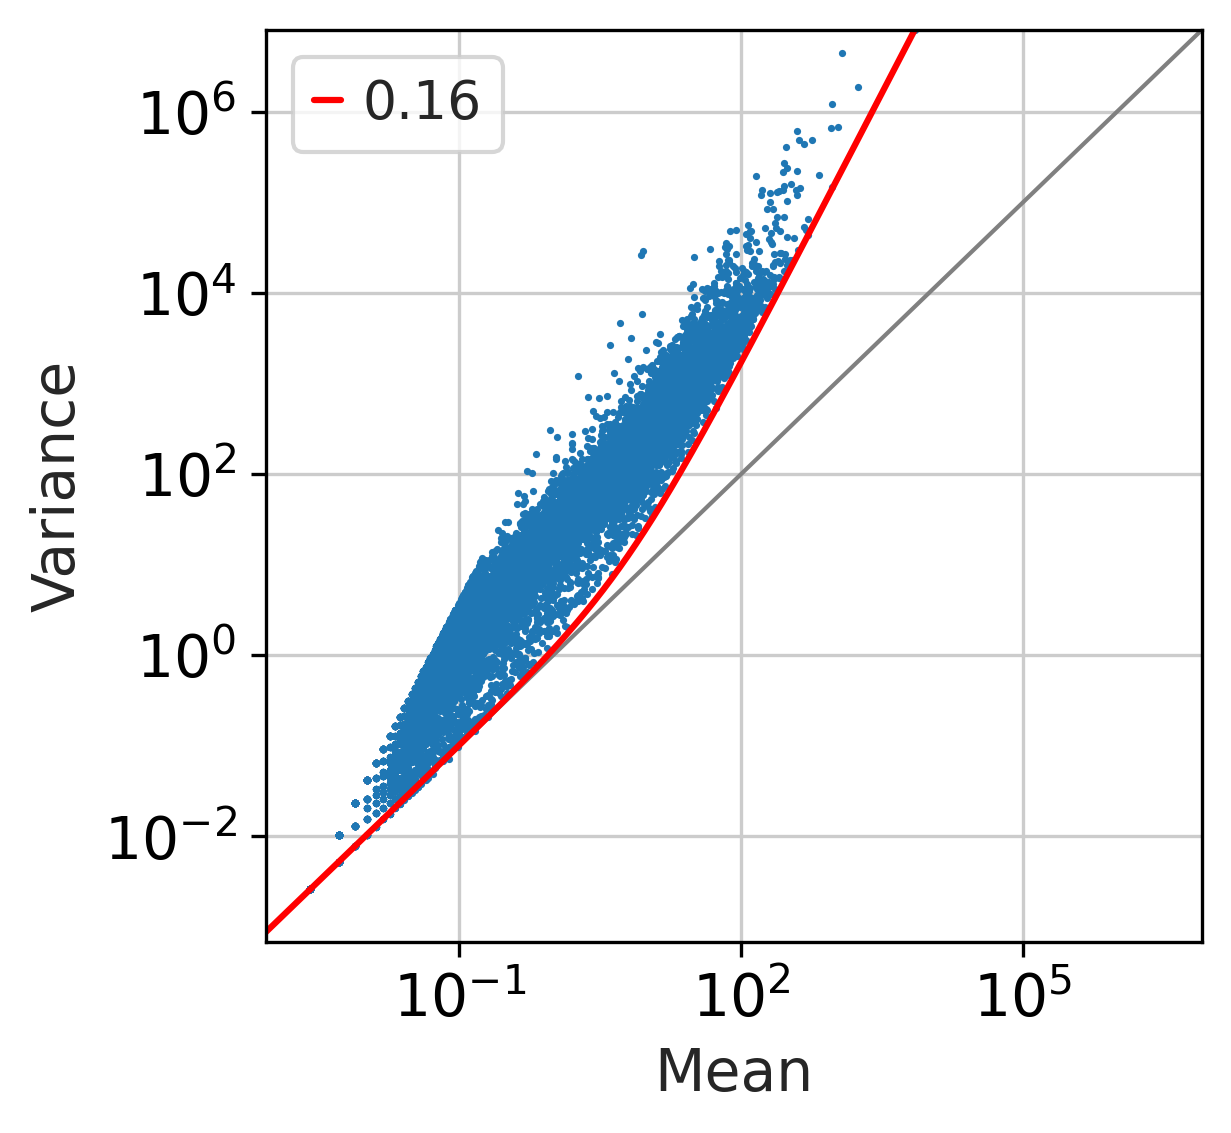

In [ ]:
mean_var_plot(adata_smart, fit_NB=True)

Сначала аналогично тому что в семинаре, найдем CP10k. 

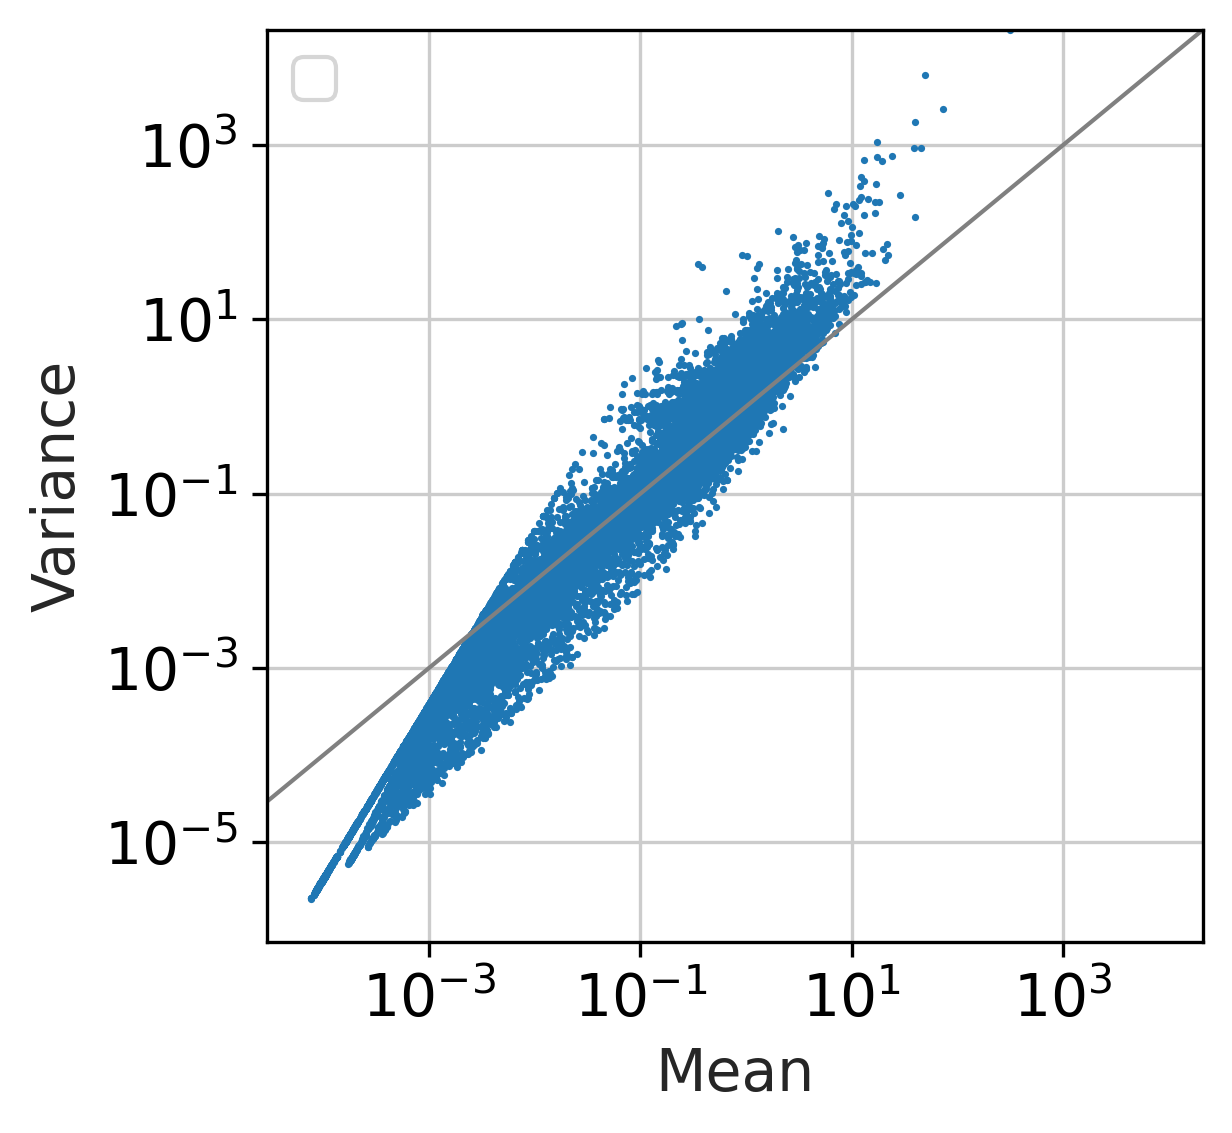

In [ ]:
adata = adata_smart.copy()
adata_raw = adata.copy()
adata = adata_raw.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
mean_var_plot(adata, log=True)

Видим, что с увеличением среднего увеличивается дисперсия, что не хорошо, хоть и ожидаемо

Посмотрим,что будет, если сделать так, чтобы сумма каунтов в каждой клетке была равна медиане

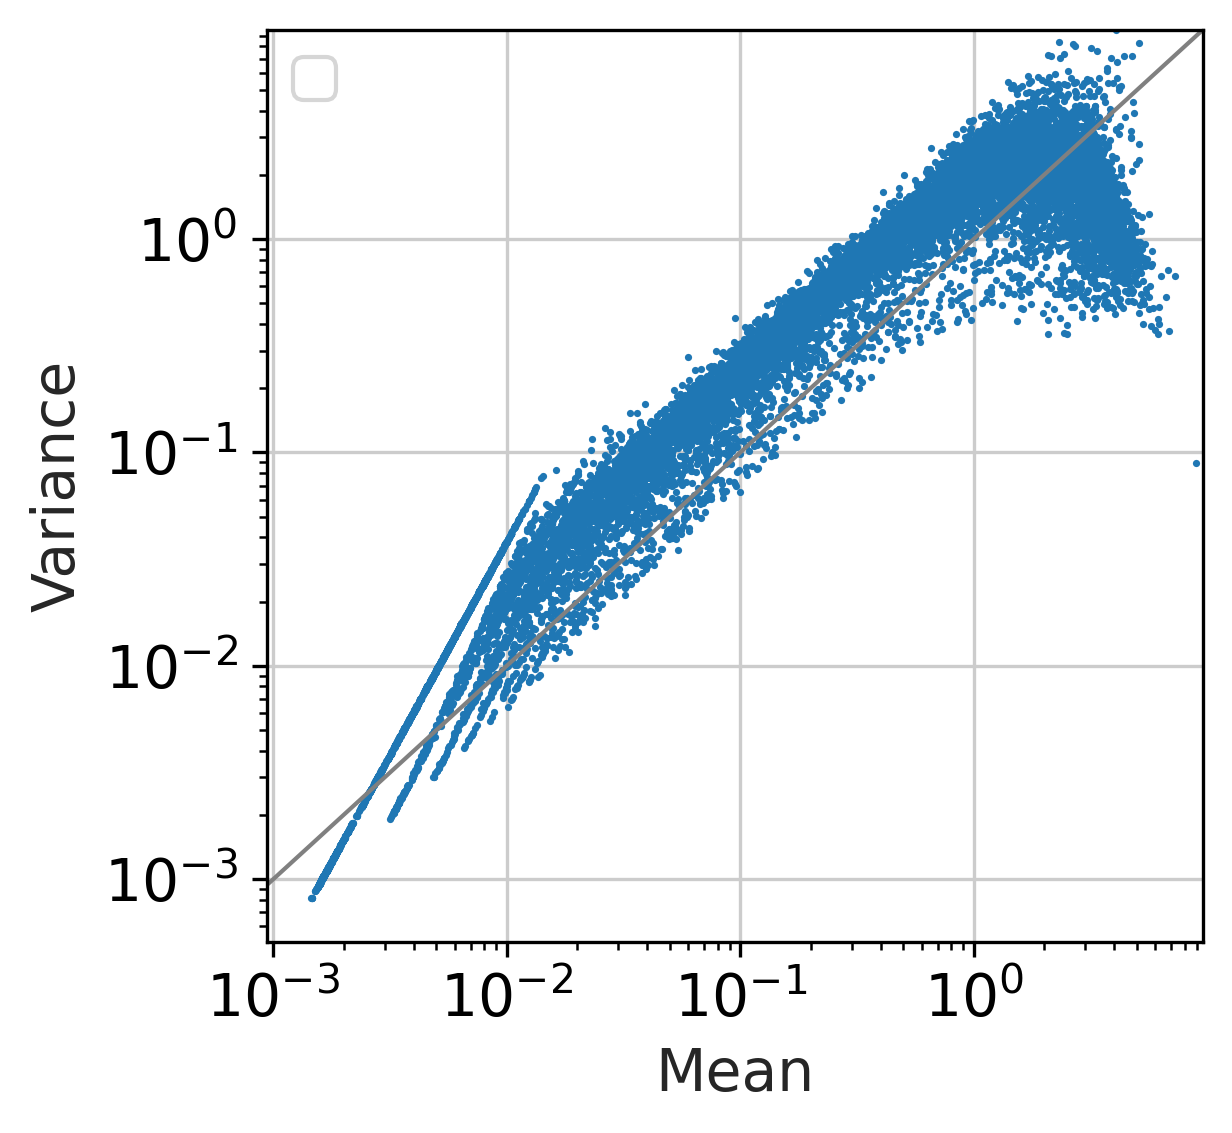

In [ ]:
adata = adata_raw.copy()
sc.pp.normalize_total(adata)  
sc.pp.log1p(adata)
mean_var_plot(adata, log=True)

Лучше не стало, зависимость все еще есть. 

Теперь отлогарифмируем

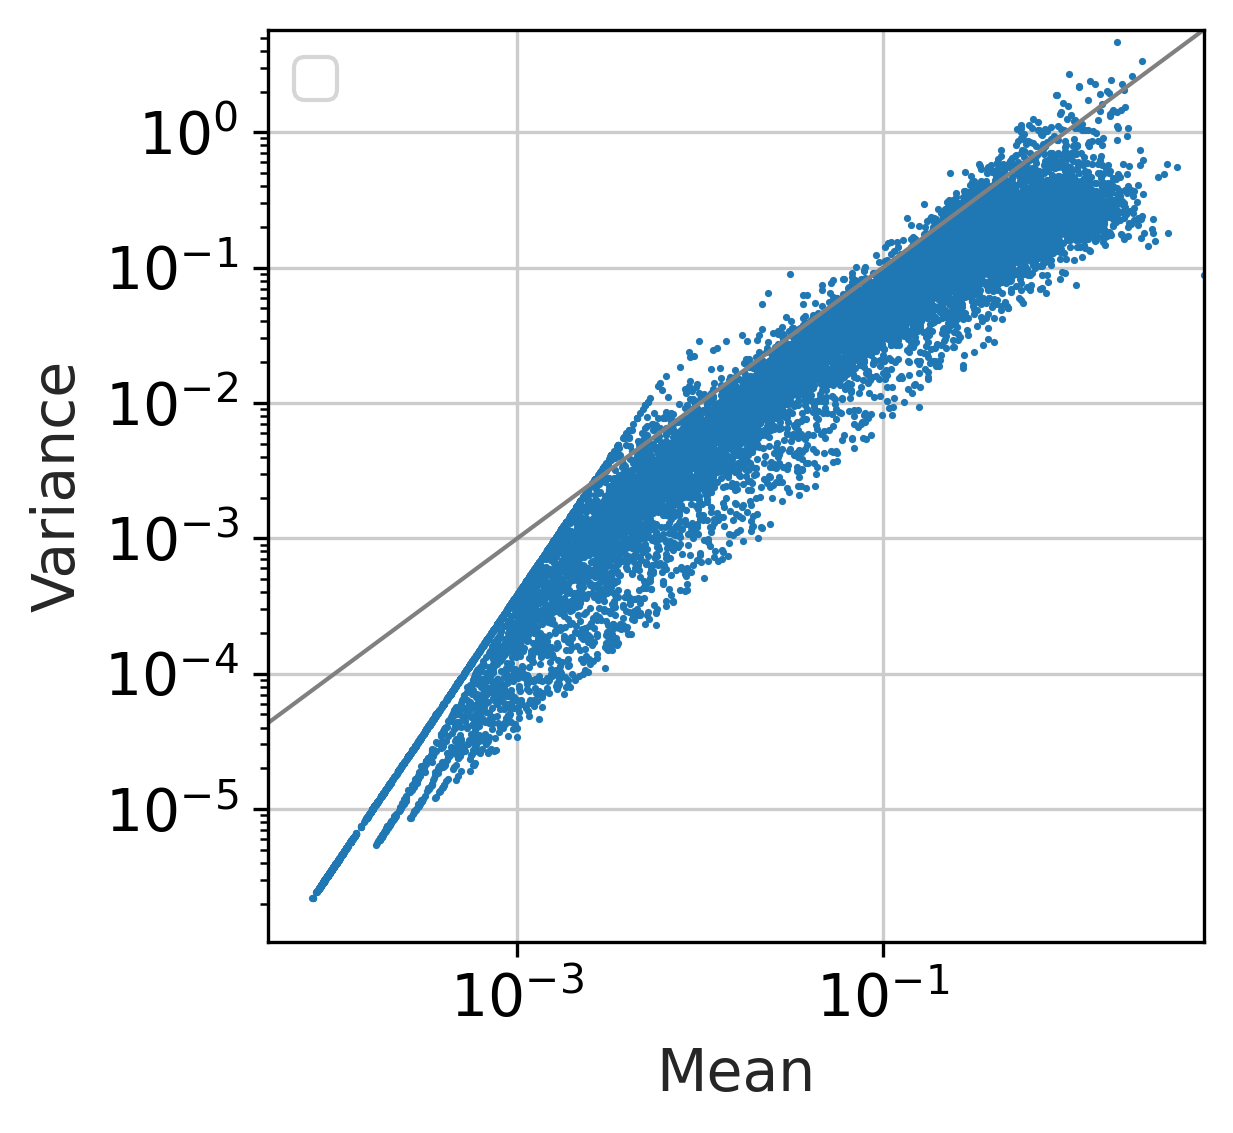

In [ ]:

adata = adata_raw.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
mean_var_plot(adata, log=True)
     

Все еще плохо. 

Можно посмотреть, что будет если взять квадратный корень

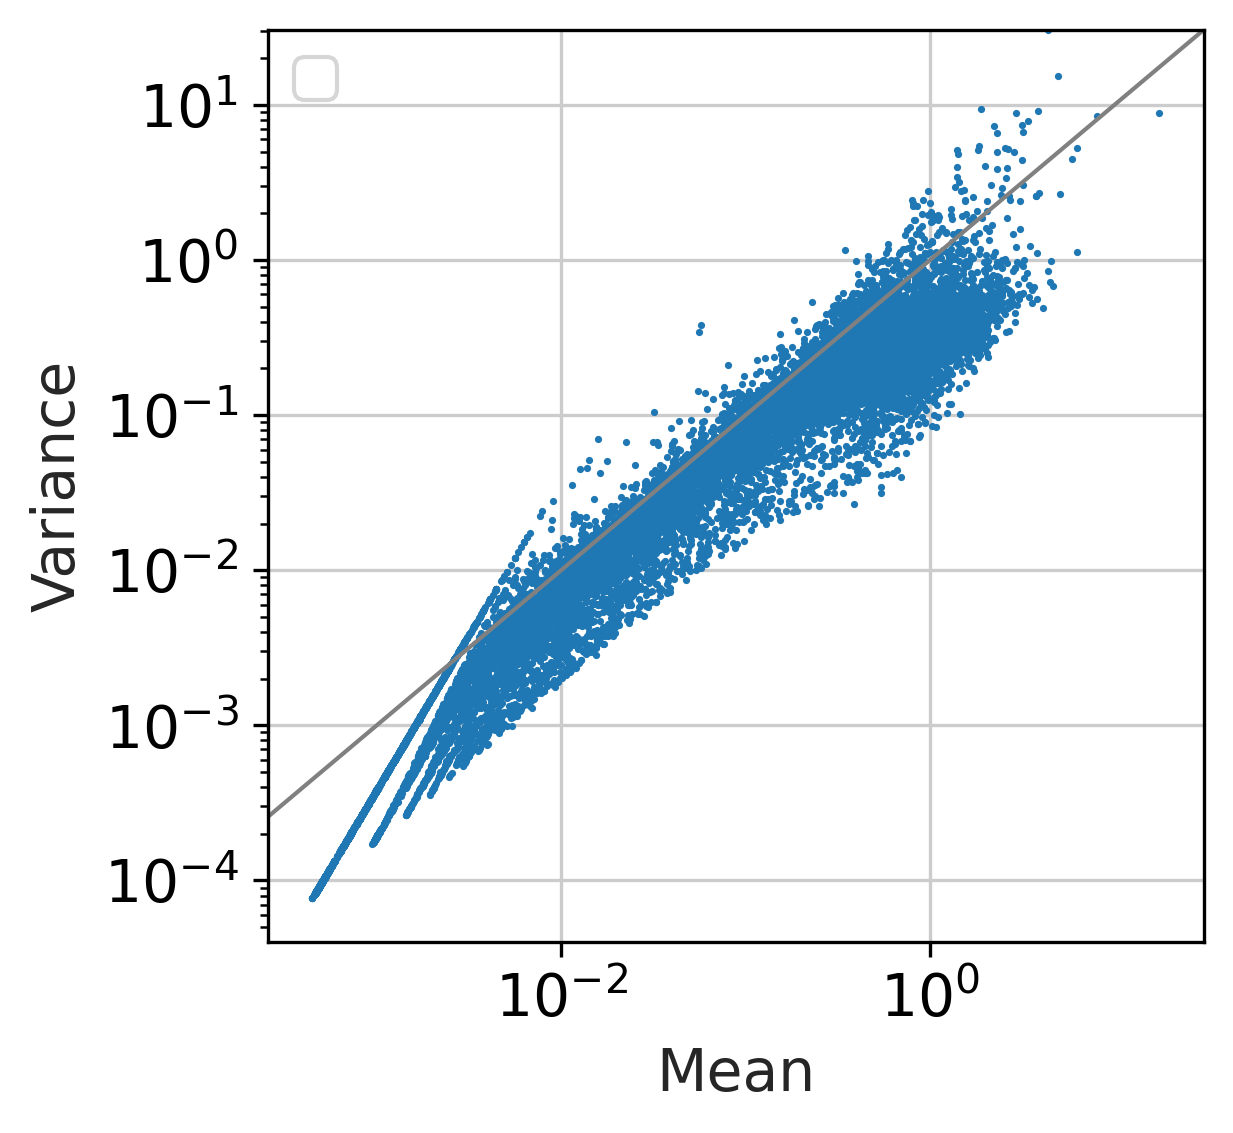

In [ ]:
adata = adata_raw.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.sqrt(adata)
mean_var_plot(adata, log=True)

Оно не очень отличается от логарифма

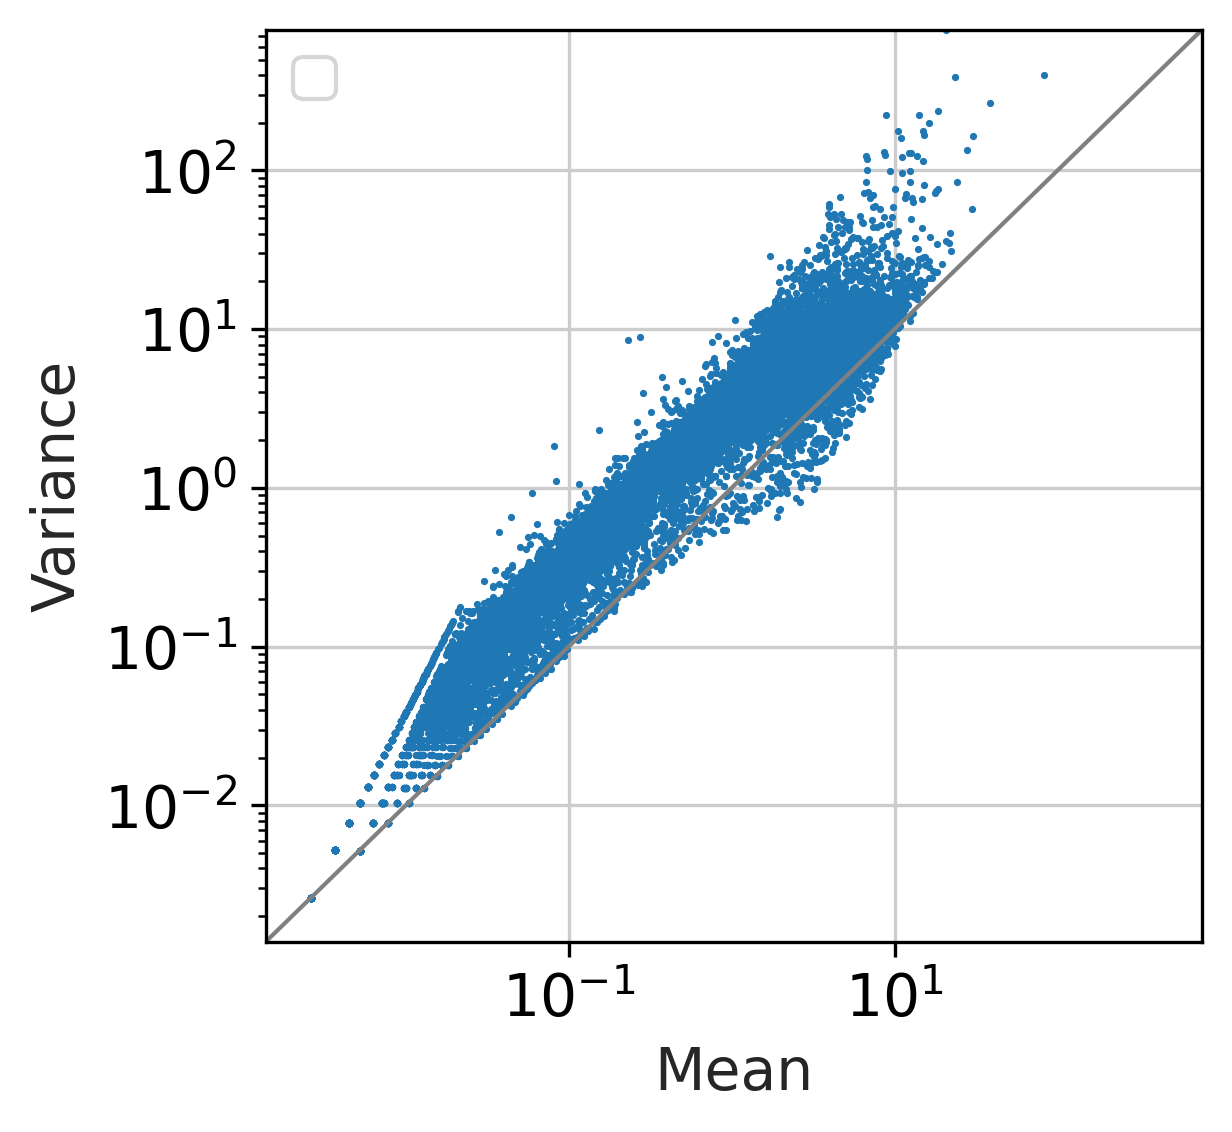

In [ ]:

adata = adata_raw.copy()
sc.pp.sqrt(adata)
mean_var_plot(adata, log=True)

И так тоже не очень. То ест при любом из этих преобразований мы не избавляемся от технической части дисперсии. 

Дальше я сначала неправильно прочитала задание, поэтому для данных smar-seq2 были проделаны и последние две трансформации из семинара, хотя логично, Analytic Pearson residuals ситуацию не улучшит (он и не улучшил), так как в его основе лежит предположение о том, что данные распределены +- по Пуассону, но с нашими данными это прям совсем не так. 

Text(0.5, 0, 'Gene expression mean')

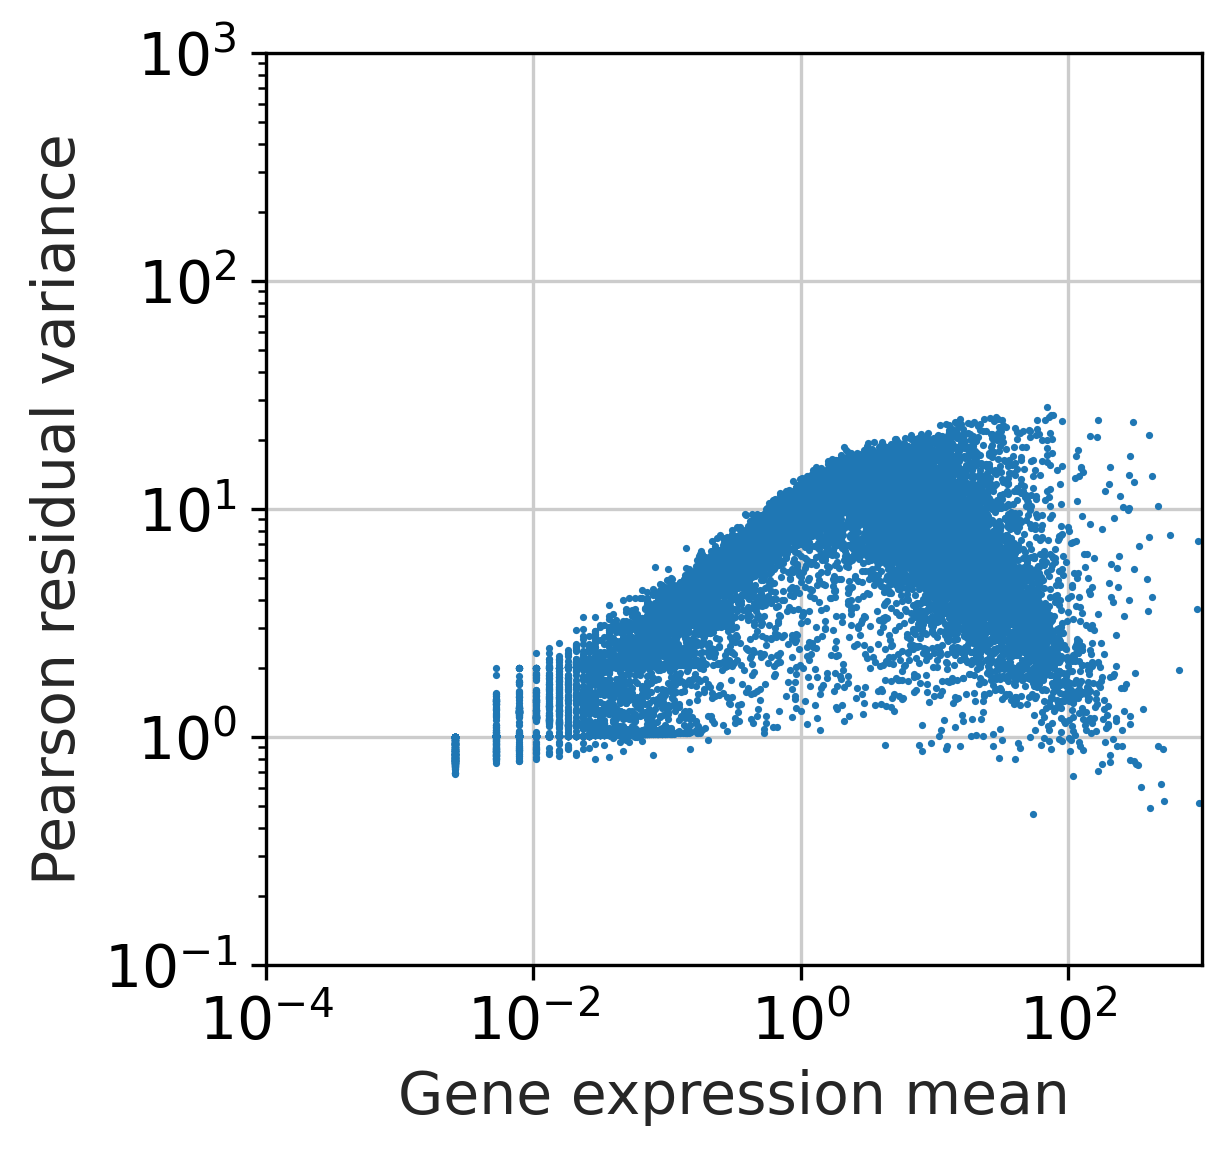

In [ ]:
adata = adata_raw.copy()
sc.experimental.pp.normalize_pearson_residuals(adata, theta = 6.25)

res_var = np.var(adata.X, axis=0)
mean = adata_raw.X.A.mean(axis=0)[res_var > 0]
res_var = res_var[res_var > 0]

ax = sns.scatterplot(x=mean, y=res_var, linewidth=0, s=3)
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlim(0.0001, 1000); ax.set_ylim(0.1, 1000)
ax.set_ylabel("Pearson residual variance"); ax.set_xlabel("Gene expression mean")

In [ ]:
adata = adata_smart.copy()
# adata_raw = adata.copy()
# adata = adata_raw.copy()
#уберем гены с нулевой экспрессией во всех клетках
adata.var['mean_val'] = adata.X.A.mean(axis=0)
p = adata.var['mean_val'] != 0
adata = adata[:, p]
#убираем повторы
a1 = list(adata.var.index)
adata = adata[:, [(a1.count(x) - 1 == 0) for x in a1]]

In [ ]:
import rpy2.robjects as ro
ro.globalenv["adata_counts"] = adata
ro.r('SCT.results <- sctransform::vst(assay(adata_counts), vst.flavor="v2")')

In [ ]:
var_SCT = ro.r("SCT.results$gene_attr")
SCT = ro.r("SCT.results$y")
cells_SCT = ro.r("SCT.results$cells_step1")

adata_SCT = adata.copy()
adata_SCT = adata_SCT[:, var_SCT.index]
adata_SCT.layers["SCTransform"] = SCT.T

Text(0.5, 0, 'Gene expression mean')

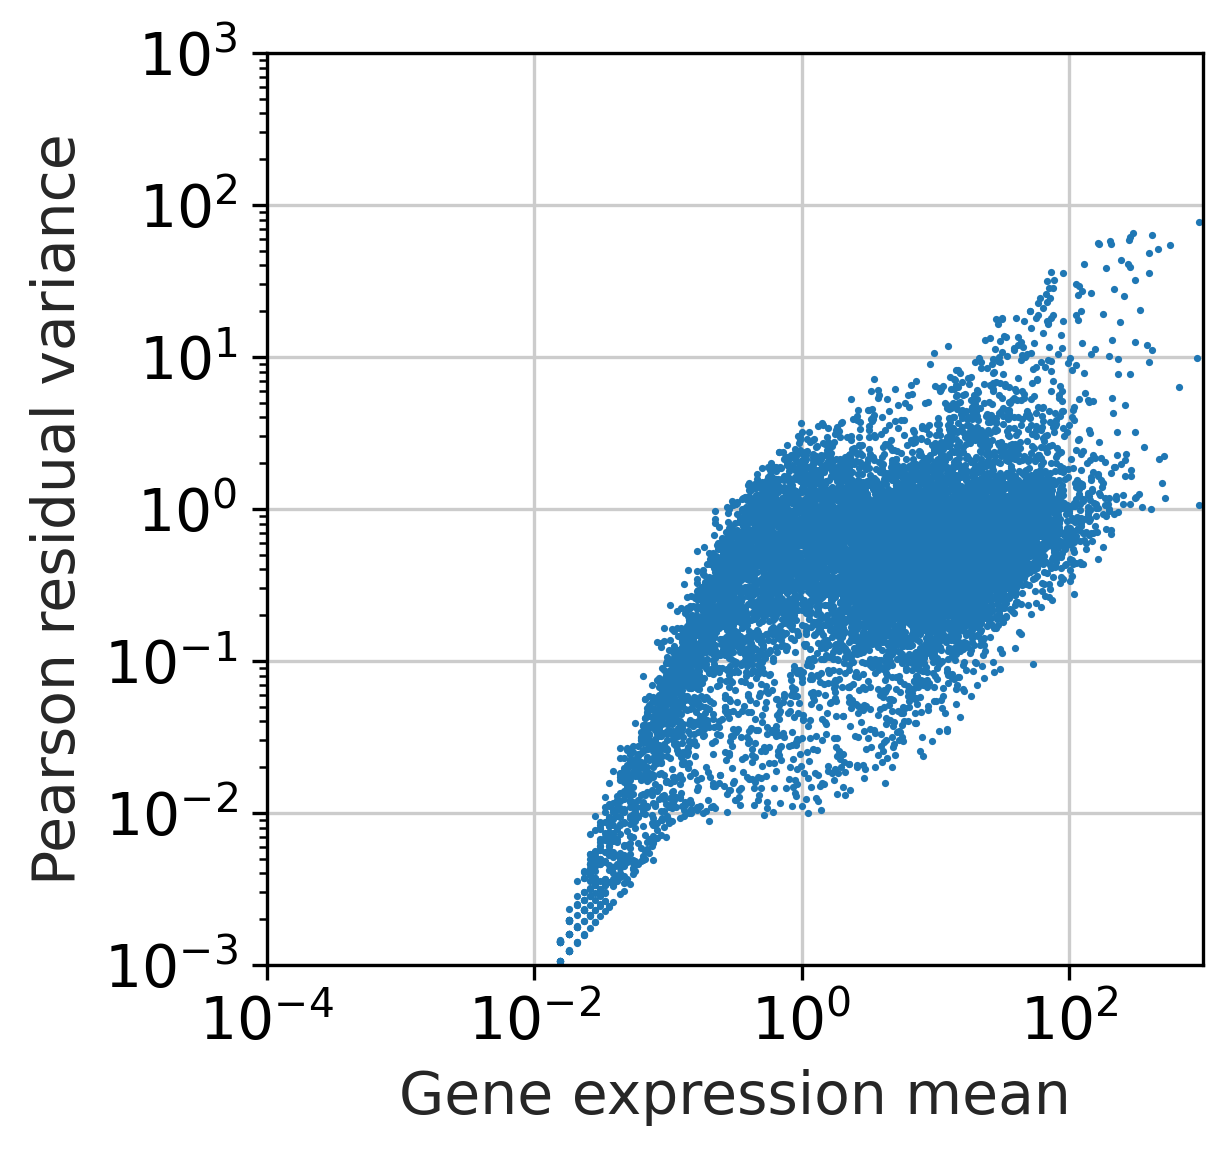

In [ ]:
res_var = np.var(adata_SCT.layers["SCTransform"], axis=0)
mean = adata_SCT.X.A.mean(axis=0)[res_var > 0]
res_var = res_var[res_var > 0]

ax = sns.scatterplot(x=mean, y=res_var, linewidth=0, s=3)
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_xlim(0.0001, 1000); ax.set_ylim(0.001, 1000)
ax.set_ylabel("Pearson residual variance"); ax.set_xlabel("Gene expression mean")

## Теперь боксплоты

In [ ]:
adata = adata_10x.copy()
#уберем гены с нулевой экспрессией во всех клетках
adata.var['mean_val'] = adata.X.A.mean(axis=0)
p = adata.var['mean_val'] != 0
adata = adata[:, p]


In [ ]:
import rpy2.robjects as ro
ro.globalenv["adata_counts"] = adata
ro.r('SCT.results <- sctransform::vst(assay(adata_counts), vst.flavor="v2")')


In [ ]:
var_SCT = ro.r("SCT.results$gene_attr")
SCT = ro.r("SCT.results$y")
cells_SCT = ro.r("SCT.results$cells_step1")

adata_SCT = adata.copy()
adata_SCT = adata_SCT[:, var_SCT.index]
adata_SCT.layers["SCTransform"] = SCT.T

In [ ]:
from scipy.stats import pearsonr
adata = adata_SCT.copy()
adata.obs["total_exp"] = adata.X.A.sum(axis=1)
n_exp = np.array(adata.obs["total_exp"])

In [ ]:
adata_PF = sc.pp.normalize_total(adata, copy=True)
adata_log1pPF = sc.pp.log1p(adata_PF, copy=True)
adata_PFlog1pPF = sc.pp.normalize_total(adata_log1pPF, copy=True)
adata_Peares = sc.experimental.pp.normalize_pearson_residuals(adata, theta = 6.25, copy=True)


In [ ]:
results_r2 = pd.DataFrame({
    "PF" : [pearsonr(
        adata_PF[:, gene].X.A.T[0], n_exp
    )[0] ** 2 for gene in adata.var_names],
    "log1pPF" : [pearsonr(
        adata_log1pPF[:, gene].X.A.T[0], n_exp
    )[0] ** 2 for gene in adata.var_names],
    "PFlog1pPF" : [pearsonr(
        adata_PFlog1pPF[:, gene].X.A.T[0], n_exp
    )[0] ** 2 for gene in adata.var_names],
    "Peares" : [pearsonr(
        adata_Peares[:, gene].X.T[0], n_exp
    )[0] ** 2 for gene in adata.var_names],
    "SCT" : [pearsonr(
        adata_SCT.layers["SCTransform"].T[0], n_exp
    )[0] ** 2 for gene in adata.var_names]
}, index=adata.var_names)

In [ ]:
results_r2.head()

,PF,log1pPF,PFlog1pPF,Peares,SCT
AL627309.1,0.000068,0.000089,0.000035,0.000063,0.000058
AL669831.5,0.001365,0.002176,0.000757,0.001361,0.000058
LINC00115,0.002699,0.003454,0.001467,0.002563,0.000058
FAM41C,0.000044,0.000135,0.000008,0.000053,0.000058
NOC2L,0.002974,0.006634,0.000862,0.002831,0.000058


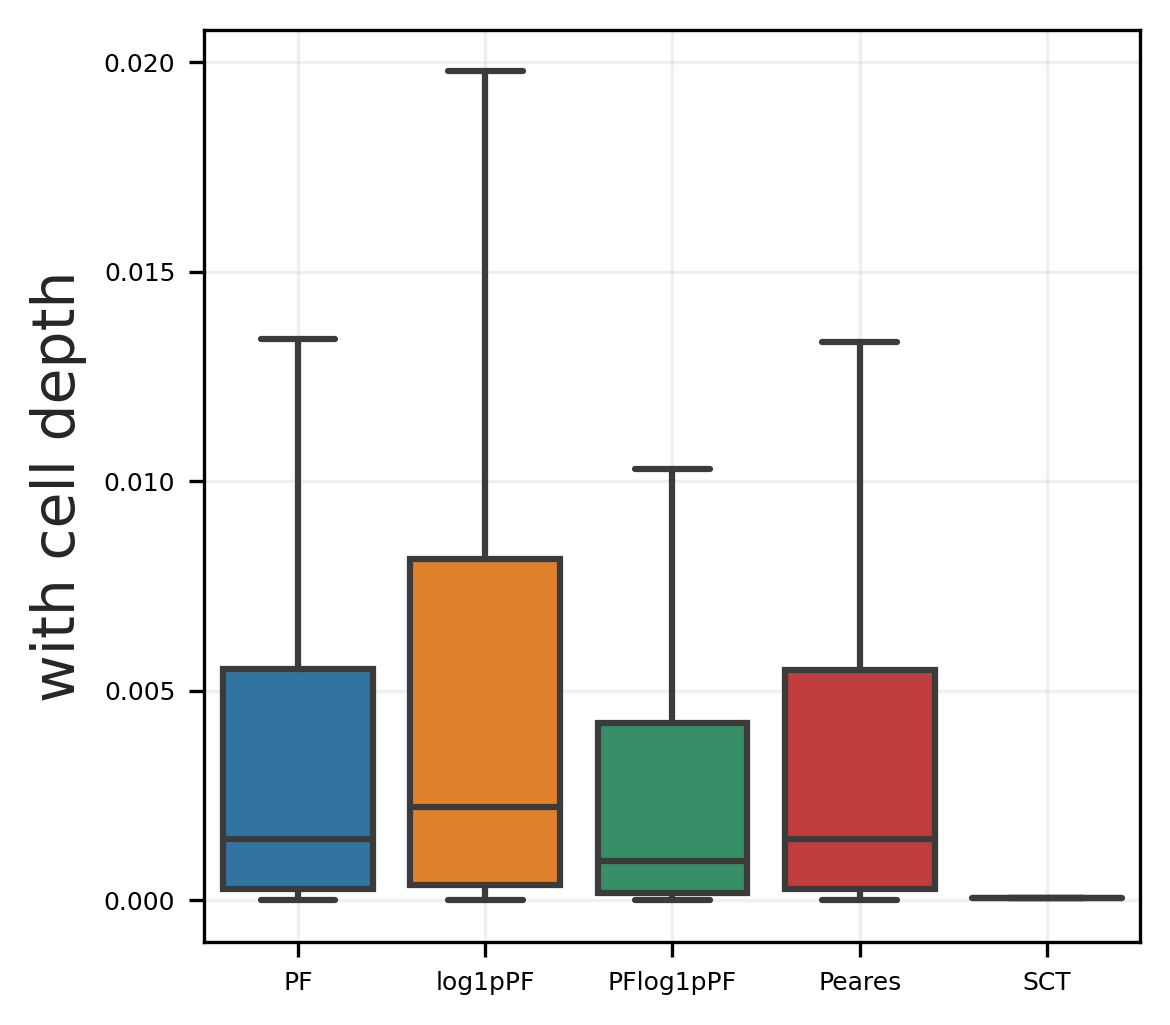

In [ ]:
ax = sns.boxplot(data=results_r2, showfliers=False)
ax.set_ylabel("with cell depth")
plt.setp(ax.get_xticklabels(), fontsize=6)
plt.setp(ax.get_yticklabels(), fontsize=6)
ax.grid(alpha=0.3)

По графику видно, что SCT лучше всего справляется с устранением зависимости, что соотносится с тем, что мы наблюдали на графиках на семинаре